# Project - Regressors

## Initialization

Import libraries

In [1]:
import glob
import os

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

from operator import itemgetter, attrgetter

from matplotlib import pyplot as plt

#### Prepare parallel kernel

*Install [here](https://ipyparallel.readthedocs.io/en/latest/), define the number of engines and click '**Start**' in the* **iPython Clusters** *tab.*

Import parallel computing libraries and register processors

In [2]:
from ipyparallel import Client
from ipyparallel.joblib import IPythonParallelBackend
from joblib import Parallel, parallel_backend, register_parallel_backend

On Noto, run `ipcontroller --ip="*"`

In [3]:
c = Client(profile='default')
print('profile:', c.profile)
print("IDs:", c.ids) # Process id numbers
bview = c.load_balanced_view()
register_parallel_backend('ipyparallel',
                          lambda : IPythonParallelBackend(view=bview))

profile: default
IDs: [0, 1, 2, 3, 4, 5, 6, 7]


---

## Function definitions

Read datasets

In [4]:
def pp_rf(test_size):
    
    list_of_files = glob.glob('50_by_100/Full*.csv') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    
    print('Latest file : ', latest_file)

    df_raw = pd.read_csv(latest_file, index_col=0)
    #df_raw.sort_index(inplace = True, ascending = True)
    #df_raw.sort_index(inplace = True, axis = 1)

    y = df_raw.COVID.copy()
    X = df_raw.drop(columns = ['COVID']).copy()
    
    X_types = dict(X.dtypes)
    features = list(X.columns)
    
    train = np.random.rand(len(df_raw))> test_size

    X_train = X[train]
    X_test = X[~train]

    y_train = y[train].tolist()
    y_test = y[~train].tolist()

    return X, X_train, X_test, y, y_train, y_test

Define plotting functions

In [5]:
def plot_importance(feature_importance_sorted, n, type_of_search):
    
    plt.figure(figsize=(15,10))
    x = np.arange(n)
    y = [feature_importance_sorted[i][1] for i in range(n)]
    labels = [feature_importance_sorted[i][0] for i in range(n)]
    ax = sns.barplot(y,x,orient="h");
    plt.xlabel("Importance fraction", fontsize = 15)
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()], fontsize = 15)
    plt.yticks(x,labels, fontsize = 15)
    plt.title('Most important feature: {}'.format(type_of_search), fontsize = 15)
    
    plt.tight_layout()
    plt.savefig('Feature rank '+type_of_search+'.png')
    plt.show();

In [6]:
def plot_cumulative(feature_importance_sorted, type_of_search):
    sorted_importances = [importance[1] for importance in feature_importance_sorted]
    sorted_features = [importance[0] for importance in feature_importance_sorted]
    x_values = list(range(len(feature_importance_sorted)))

    cumulative_importances = np.cumsum(sorted_importances)
    
    plt.figure(figsize=(15,5))
    plt.plot(x_values, cumulative_importances, 'g-')
    plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
    plt.xlabel('Number of variables', fontsize = 15)
    plt.ylabel('Cumulative Importance', fontsize = 15)
    plt.title('Cumulative Importances', fontsize = 15)
    
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    
    plt.tight_layout()
    plt.savefig('Cumulative importance '+type_of_search+'.png')
    plt.show()
    
    limit = np.where(cumulative_importances > 0.95)[0][0] + 1
    print('Number of features for 95% importance:', limit)
    
    return limit

## Random Forest Regressor

We will compare two methods, which are grid search and random search.

In [7]:
X, X_train, X_test, y, y_train, y_test = pp_rf(0.3)

Latest file :  50_by_100/Full-2020_05_10-13_14_09-X_raw_disease_50_target_100_7217_by_101.csv


In [8]:
rf_reg = RandomForestRegressor(n_jobs=-1)

### Random Search

After having explored a grid search, we can adopt another approach. Instead of searching for each value, let's give our model more parameters as inputs, but instead let it choose randomly at each iteration one value for each parameter. It will then be evaluated again.

In [9]:
n_estimators = range(10,1000,50)
criterion = ['mse', 'mae']
max_depth = range(5,20)
min_samples_split = range(2,10,2)
min_samples_leaf = range(1,2)
max_features = ['sqrt', 'log2', None]
bootstrap = [True]

random_parameters = {'n_estimators' : n_estimators,
                     'criterion' : criterion,
                     'max_depth' : max_depth,
                     'min_samples_split' : min_samples_split,
                     'min_samples_leaf' : min_samples_leaf,
                     'max_features' : max_features,
                     'bootstrap' : bootstrap}

In [10]:
random_reg = RandomizedSearchCV(rf_reg,
                                param_distributions = random_parameters,
                                n_iter = 5,
                                verbose = 3)

In [11]:
with parallel_backend('ipyparallel'):
    random_reg.fit(X_train, y_train);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend IPythonParallelBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed: 25.7min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 26.8min finished


In [12]:
random_best_score = random_reg.best_score_
random_best_parameters = random_reg.best_params_
random_best_n_estimators = random_best_parameters.get('n_estimators')
random_best_criterion = random_best_parameters.get('criterion')
random_best_max_depth = random_best_parameters.get('max_depth')
random_best_min_samples_split = random_best_parameters.get('min_samples_split')
random_best_min_samples_leaf = random_best_parameters.get('min_samples_leaf')
random_best_max_features = random_best_parameters.get('max_features')
random_best_bootstrap = random_best_parameters.get('bootstrap')


print('Random search best_score: {:.5}'.format(random_best_score))

print('Random best n_estimators: {}'.format(random_best_n_estimators))
print('Random best criterion: {}'.format(random_best_criterion))
print('Random best max_depth: {}'.format(random_best_max_depth))
print('Random best min_samples_split: {}'.format(random_best_min_samples_split))
print('Random best min_samples_leaf: {}'.format(random_best_min_samples_leaf))
print('Random best max_features: {}'.format(random_best_max_features))
print('Random best bootstrap: {}'.format(random_best_bootstrap))

Random search best_score: -0.0016668
Random best n_estimators: 410
Random best criterion: mse
Random best max_depth: 5
Random best min_samples_split: 4
Random best min_samples_leaf: 1
Random best max_features: sqrt
Random best bootstrap: True


In [13]:
random_best_parameters = {'n_estimators' : [random_best_n_estimators],
                        'criterion' : [random_best_criterion],
                        'max_depth' : [random_best_max_depth],
                        'min_samples_split' : [random_best_min_samples_split],
                        'min_samples_leaf' : [random_best_min_samples_leaf],
                        'max_features' : [random_best_max_features],
                        'bootstrap' : [random_best_bootstrap]}

In [14]:
random_reg_best = GridSearchCV(rf_reg,
                               param_grid = random_best_parameters,
                               verbose = 3)

In [15]:
with parallel_backend('ipyparallel'):
    random_reg_best.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend IPythonParallelBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Let's apply it to our validation set.

In [16]:
random_y_pred = random_reg_best.predict(X_test)

In [17]:
print("Mean Squared Error : {:.5%}".format(mse(y_test, random_y_pred)))

Mean Squared Error : 0.00375%


The mean squared error is very low, so we can take a deeper look at the data.

#### Feature importance

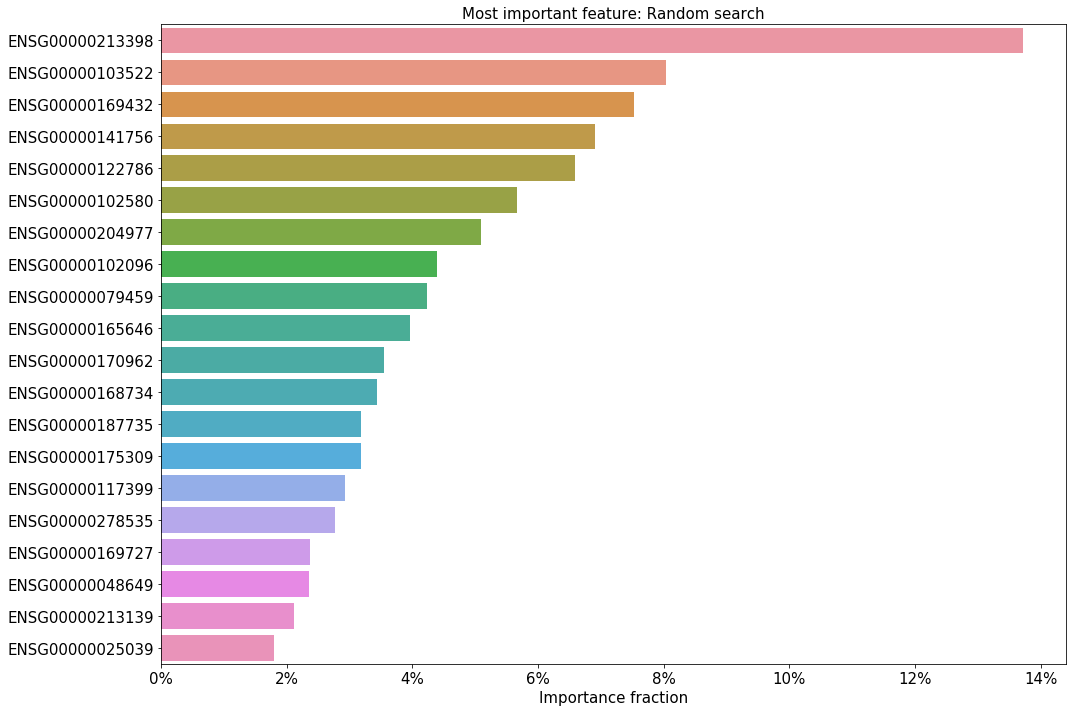

In [18]:
random_feature_importances = [(list(X.columns)[i], random_reg_best.best_estimator_.feature_importances_[i])
                              for i in range(len(list(X.columns)))]
random_feature_importances.sort(key=itemgetter(1), reverse = True)
plot_importance(random_feature_importances, 20, 'Random search')

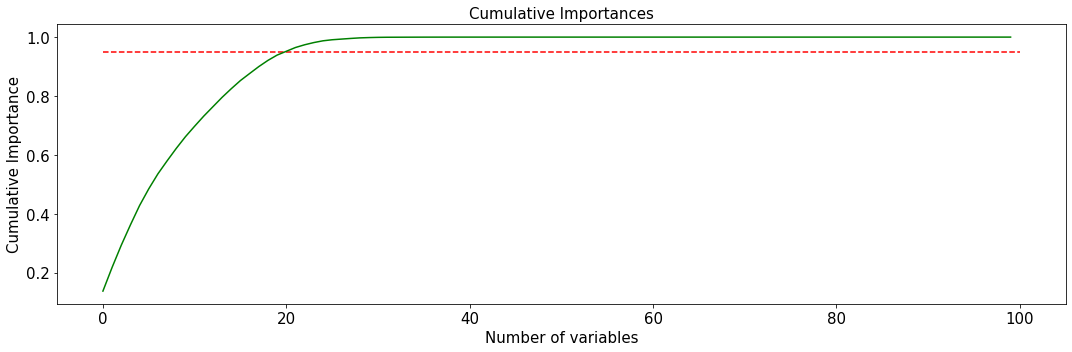

Number of features for 95% importance: 21


In [19]:
limit = plot_cumulative(random_feature_importances, 'Random search')

We print the $r^2$ score. A value above 0 indicates that the regression is better at predicting the value of y than if it was outputing only the expected value of y regardless of input features. The best possible score is 1.

Here the value is close to 0, indicating that the model is slightly better at predicting y than only outputing the expected value, but far from perfect

In [20]:
print(r2_score(y_test,random_y_pred))

0.0009199693393540098


#### Feature selection

Let's try to run the model again, but this time selecting only the most impacting features to save us some work and let's compare the results.

In [21]:
random_selected_features = [random_feature_importances[i][0]
                            for i in range(15)]
random_X_train_sel = X_train[random_selected_features]
random_X_test_sel = X_test[random_selected_features]

In [22]:
with parallel_backend('ipyparallel'):
    random_reg.fit(random_X_train_sel, y_train);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend IPythonParallelBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:  1.1min remaining:   21.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.3min finished


In [23]:
random_best_score_sel = random_reg.best_score_
random_best_parameters_sel = random_reg.best_params_
random_best_n_estimators_sel = random_best_parameters_sel.get('n_estimators')
random_best_criterion_sel = random_best_parameters_sel.get('criterion')
random_best_max_depth_sel = random_best_parameters_sel.get('max_depth')
random_best_min_samples_split_sel = random_best_parameters_sel.get('min_samples_split')
random_best_min_samples_leaf_sel = random_best_parameters_sel.get('min_samples_leaf')
random_best_max_features_sel = random_best_parameters_sel.get('max_features')
random_best_bootstrap_sel = random_best_parameters_sel.get('bootstrap')


print('Random search best_score: {:.5}'.format(random_best_score_sel))

print('Random best n_estimators: {}'.format(random_best_n_estimators_sel))
print('Random best criterion: {}'.format(random_best_criterion_sel))
print('Random best max_depth: {}'.format(random_best_max_depth_sel))
print('Random best min_samples_split: {}'.format(random_best_min_samples_split_sel))
print('Random best min_samples_leaf: {}'.format(random_best_min_samples_leaf_sel))
print('Random best max_features: {}'.format(random_best_max_features_sel))
print('Random best bootstrap: {}'.format(random_best_bootstrap_sel))

Random search best_score: -0.00084545
Random best n_estimators: 910
Random best criterion: mse
Random best max_depth: 5
Random best min_samples_split: 8
Random best min_samples_leaf: 1
Random best max_features: log2
Random best bootstrap: True


In [24]:
random_best_parameters_sel = {'n_estimators' : [random_best_n_estimators_sel],
                              'criterion' : [random_best_criterion_sel],
                              'max_depth' : [random_best_max_depth_sel],
                              'min_samples_split' : [random_best_min_samples_split_sel],
                              'min_samples_leaf' : [random_best_min_samples_leaf_sel],
                              'max_features' : [random_best_max_features_sel],
                              'bootstrap' : [random_best_bootstrap_sel]}

In [25]:
random_reg_best_sel = GridSearchCV(rf_reg,
                                   param_grid = random_best_parameters_sel,
                                   return_train_score = True,
                                   verbose = 3)

In [26]:
with parallel_backend('ipyparallel'):
    random_reg_best_sel.fit(random_X_train_sel, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend IPythonParallelBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


In [27]:
random_y_pred_sel = random_reg_best_sel.predict(random_X_test_sel)

In [28]:
print("Mean Squared Error: {:.5%}".format(mse(y_test, random_y_pred_sel)))

Mean Squared Error: 0.00375%


In [29]:
print(r2_score(y_test,random_y_pred_sel))

0.00048797298004477074


As expected, the mean squared error and $r^2$ scores are slightly worse than for the full dataset. The computational time has not varied much however.